# P_bar Notebook

In this notebook, I will change the order of coordinate transformation steps so that individuals are converted from a vertical coordinate of p to one of p_bar(rho). Then, after this has been done for individual temperature and salinity profiles, I will perform the rest of the analysis steps to calculate variance production, eddy diffusivity, and eddy fluxes. At some ppoint I'd also like to do a side-by-side comparison between the results for this order, and the order of moving to p_bar space at the end.

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.path import Path
import matplotlib.colors as colors
import pandas as pd
import numpy as np
from importlib import reload
import cartopy.crs as ccrs
import cmocean.cm as cmo
import gsw
import scipy.ndimage as filter
import scipy.interpolate as interpolate

In [2]:
import os
os.chdir('/home/amf2288/argo-intern/funcs')
import filt_funcs as ff
import density_funcs as df

In [3]:
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.titlesize']  = 18
plt.rcParams['axes.labelsize']  = 14
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14

## Load Dataset and Make Section

In [40]:
ds_x = xr.open_dataset('/swot/SUM05/amf2288/sync-boxes/ds_high_res_1.nc')

In [41]:
section = ds_x.where((ds_x.LATITUDE < -25) & (ds_x.LATITUDE > -35),drop=True).where((ds_x.LONGITUDE < -138) & (ds_x.LONGITUDE > -140),drop=True).sortby('LATITUDE')

In [42]:
section = section.sortby('N_PROF')

In [43]:
#only keep profiles with at least n data points
ct_counts = section['CT'].count(dim='PRES_INTERPOLATED')
profiles_to_keep = ct_counts >= 500
section_p = section.sel(N_PROF=profiles_to_keep).sortby('LATITUDE')

In [44]:
section_p = section_p.rename({'N_PROF':'PROFILE','PRES_INTERPOLATED':'PRESSURE','LATITUDE':'LAT','LONGITUDE':'LON'})
section_p

<xarray.Dataset>
Dimensions:          (PROFILE: 409, PRESSURE: 1001)
Coordinates:
  * PRESSURE         (PRESSURE) int64 0 2 4 6 8 10 ... 1992 1994 1996 1998 2000
  * PROFILE          (PROFILE) int64 1983300 1983280 1984183 ... 1264653 1263963
    TIME             (PROFILE) datetime64[ns] 2018-03-28T01:11:23 ... 2017-09...
    LAT              (PROFILE) float64 -34.9 -34.88 -34.81 ... -25.3 -25.1 -25.1
    LON              (PROFILE) float64 -138.6 -138.7 -138.5 ... -139.6 -139.4
Data variables:
    CT               (PROFILE, PRESSURE) float64 nan 20.88 20.89 ... 1.966 nan
    CYCLE_NUMBER     (PROFILE, PRESSURE) float64 nan 95.0 95.0 ... 76.0 76.0 nan
    PLATFORM_NUMBER  (PROFILE, PRESSURE) float64 nan 5.902e+06 ... 5.902e+06 nan
    PRES             (PROFILE, PRESSURE) float32 nan 2.0 4.0 ... 1.998e+03 nan
    PSAL             (PROFILE, PRESSURE) float32 nan 34.59 34.59 ... 34.63 nan
    SA               (PROFILE, PRESSURE) float64 nan 34.75 34.75 ... 34.8 nan
    SIG0             (PROFILE, PRESSURE) float64 nan 24.22 24.22 ... 27.69 nan
    TEMP             (PROFILE, PRESSURE) float32 nan 20.88 20.88 ... 2.104 nan
    sample_rate      (PROFILE, PRESSURE) float32 nan 0.9 1.0 ... 2.0 2.0 nan
    SPICE            (PROFILE, PRESSURE) float64 nan 3.434 3.436 ... -0.1042 nan
Attributes:
    DATA_ID:              ARGO
    DOI:                  http://doi.org/10.17882/42182
    Fetched_from:         https://data-argo.ifremer.fr
    Fetched_by:           amf2288
    Fetched_date:         2025/03/11
    Fetched_constraints:  [x=0.00/5.00; y=40.00/45.00; z=0.0/2002.0]
    Fetched_uri:          
    Valid uris:           ['https://data-argo.ifremer.fr/dac/coriolis/6903068...
    All uris:             ['https://data-argo.ifremer.fr/dac/coriolis/6903068...
    Processing_history:   [PRES,TEMP,PSAL] real-time and adjusted/delayed var...

## Coord interp to rho (density)

In [45]:
def interp_to_rho(rho_profile, var_profile, rho_grid, flag='group'):
    
    valid = ~np.isnan(rho_profile) & ~np.isnan(var_profile)
    rho_nonan = rho_profile[valid]
    var_nonan = var_profile[valid]

    if len(rho_nonan) < 3 or len(var_nonan) < 3:
        return np.full_like(rho_grid, np.nan)

    if flag == 'group':
        _, idx = np.unique(rho_nonan, return_index=True)
        rho_nonan = rho_nonan[idx]
        var_nonan = var_nonan[idx]

    fvar = interpolate.PchipInterpolator(rho_nonan, var_nonan, extrapolate=False)
    return fvar(rho_grid)

In [46]:
def get_ds_rho(ds_z, da_SIG0, rho_grid, variables, dim1='PROFILE', dim2='PRESSURE'):

    xrs = []
    rho_size = rho_grid.size
    
    for var in variables:
        var_interp = xr.apply_ufunc(interp_to_rho, da_SIG0, ds_z[var],
            input_core_dims=[[dim2], [dim2]],
            output_core_dims=[['rho_grid']],
            dask_gufunc_kwargs={'output_sizes': {'rho_grid': rho_size}},
            vectorize=True,
            dask='parallelized',
            kwargs={'rho_grid': rho_grid},
            output_dtypes=[ds_z[var].dtype])
        print(f'Completed comp for {var}')
        var_interp = xr.DataArray(
            data=var_interp.data,
            dims=[dim1, 'rho_grid'],
            coords={'rho_grid': rho_grid, dim1: ds_z[dim1]},
            name=var)
        xrs.append(var_interp)
        print(f'Completed {var}')
    
    ds_rho = xr.merge(xrs)
    print(f'Completed merge')
    ds_rho = ds_rho.assign_coords(LAT  =(dim1, ds_z.LAT.data))
    ds_rho = ds_rho.assign_coords(LON  =(dim1, ds_z.LON.data))
    ds_rho = ds_rho.assign_coords(TIME      =(dim1, ds_z.TIME.data))
    
    return ds_rho

In [47]:
section_rho = get_ds_rho(section_p, section_p.SIG0, np.arange(21,29,0.0025), ['CT','SA','SIG0','SPICE','PRES','PRESSURE'])

Completed comp for CT
Completed CT
Completed comp for SA
Completed SA
Completed comp for SIG0
Completed SIG0
Completed comp for SPICE
Completed SPICE
Completed comp for PRES
Completed PRES


/home/amf2288/miniconda3/envs/Argo_Feb_25/lib/python3.11/site-packages/numpy/lib/function_base.py:2506: RuntimeWarning: invalid value encountered in cast
  output[index] = result


Completed comp for PRESSURE
Completed PRESSURE
Completed merge


In [48]:
section_rho = section_rho.rename({'rho_grid':'DENSITY'})

## Coord interp to pmean (average isopycnal depth)

NOTE!!! I modified this function to put calculating pmean_smooth in the get_ds_pmean function. This means that there is one density-depth relationship used for the whole region (which is what happens in a gridded section too, except that there's only one profile for each bin, so this is iterated through like the var profiles).

In [49]:
def interp_to_pmean(var_profile, pmean_smooth, pmean_grid, roll):

    try:
        valid = ~np.isnan(var_profile) & ~np.isnan(pmean_smooth)
        var_nonan = var_profile[valid]
        pmean_nonan = pmean_smooth[valid]

        # The ValueError is raised here if pmean_nonan is not strictly increasing.
        if len(pmean_nonan) < 3:
            return np.full_like(pmean_grid, np.nan)

        fvar = interpolate.PchipInterpolator(pmean_nonan, var_nonan, extrapolate=False)
        return fvar(pmean_grid)

    except ValueError:
        # Catch the error for this specific profile and return NaNs
        #print(f"ValueError")
        return np.full_like(pmean_grid, np.nan)

In [52]:
def get_ds_pmean(ds_rho, pmean_grid, variables, roll=50, dim1='PROFILE', dim2='DENSITY'):
    
    xrs = []
    pmean_size = pmean_grid.size
    
    pres_profile = ds_rho.PRES.mean(dim1)
    #pres_da = xr.DataArray(pres_profile, dims=['rho_grid'])
    pmean_smooth = pres_profile.rolling(**{dim2: roll}, center=True).mean()
    
    for var in variables:
        var_interp = xr.apply_ufunc(interp_to_pmean, ds_rho[var], pmean_smooth,
                                   input_core_dims=[[dim2], [dim2]],
                                   output_core_dims=[['Pmean_grid']],
                                   dask_gufunc_kwargs={'output_sizes': {'Pmean_grid':pmean_size}},
                                   vectorize=True,
                                   dask='parallaleized',
                                   kwargs={'pmean_grid':pmean_grid, 'roll':roll},
                                   output_dtypes=[ds_rho[var].dtype])
        print(f'Completed comp for {var}')
        var_interp = xr.DataArray(
            data=var_interp.data,
            dims=[dim1,'pmean_grid'],
            coords={'pmean_grid': pmean_grid, dim1: ds_rho[dim1]},
            name=var)
        xrs.append(var_interp)
        print(f'Completed {var}')
        
    ds_pmean = xr.merge(xrs)
    print(f'Completed merge')
    ds_pmean = ds_pmean.assign_coords(LAT  = (dim1, ds_rho.LAT.data))
    ds_pmean = ds_pmean.assign_coords(LON  = (dim1, ds_rho.LON.data))
    #ds_pmean = ds_pmean.assign_coords(TIME      = (dim1, ds_rho.TIME.data))
    
    return ds_pmean

In [54]:
section_pmean = get_ds_pmean(section_rho, np.linspace(0, 2000, 1001), ['CT','SA','SIG0','SPICE','PRES'], dim1='PROFILE', dim2='DENSITY')

Completed comp for CT
Completed CT
Completed comp for SA
Completed SA
Completed comp for SIG0
Completed SIG0
Completed comp for SPICE
Completed SPICE
Completed comp for PRES
Completed PRES
Completed merge


In [55]:
section_pmean = section_pmean.rename({'pmean_grid':'PRESSURE_mean'})

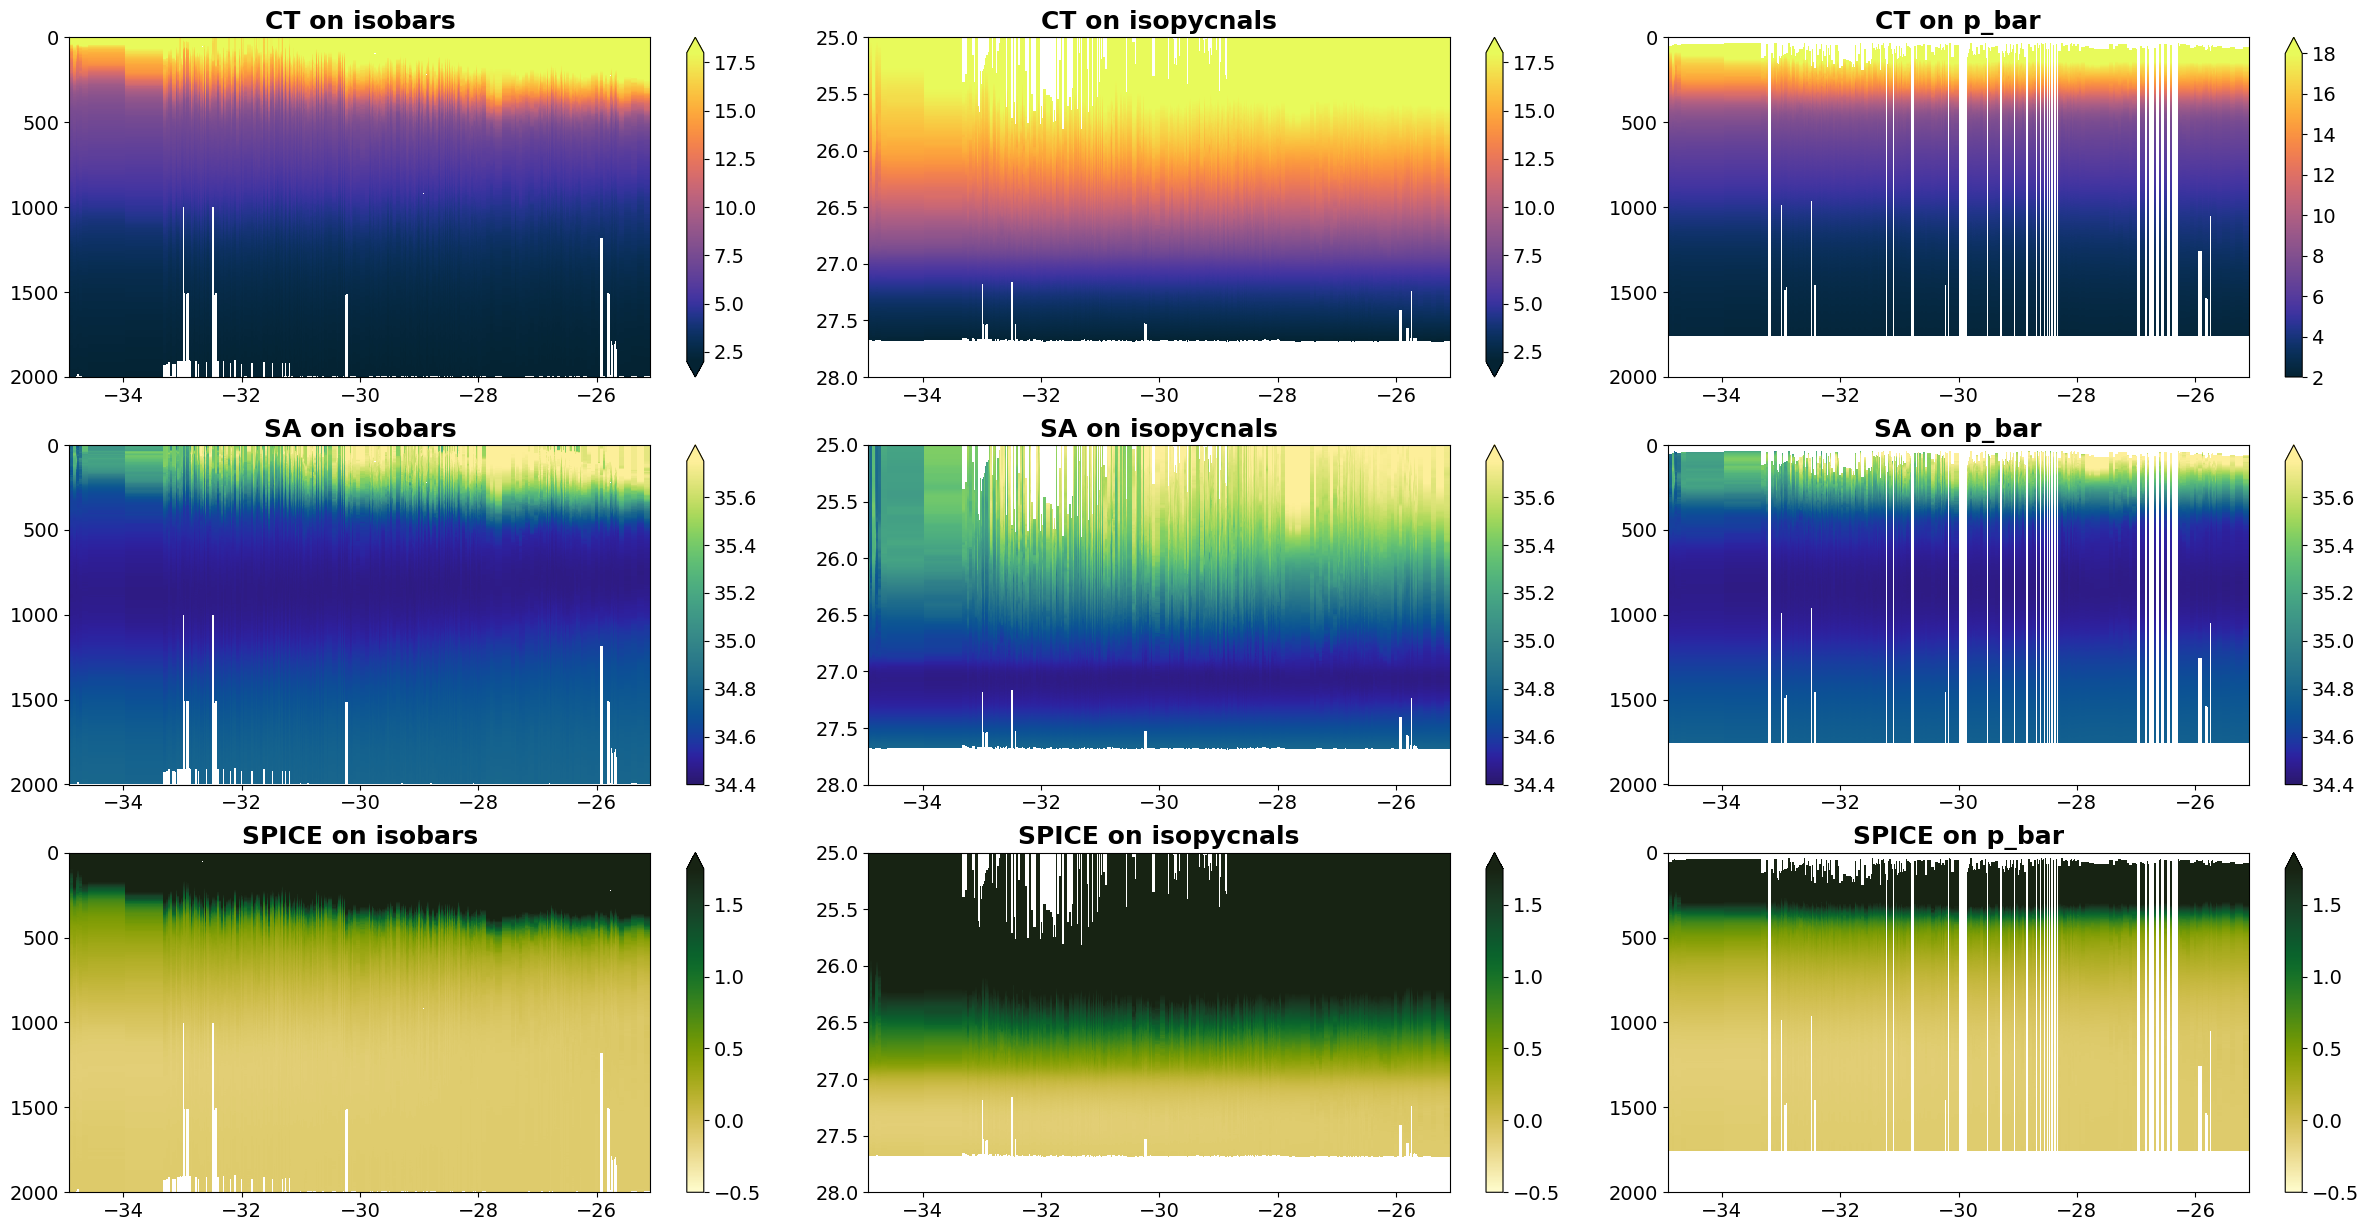

In [56]:
plt.figure(figsize=(30,15))
x = 'LAT'
ct_cmap = cmo.thermal
ct_norm = colors.Normalize(vmin=2, vmax=18)
sa_cmap = cmo.haline
sa_norm = colors.Normalize(vmin=34.4, vmax=35.75)
sp_cmap = cmo.speed
sp_norm = colors.Normalize(vmin=-0.5, vmax=1.75)

plt.subplot(331)
section_p.CT.sortby(x).plot(x=x, y='PRESSURE', cmap=ct_cmap, norm=ct_norm, add_labels=False)
plt.gca().invert_yaxis()
plt.title('CT on isobars')

plt.subplot(332)
section_rho.CT.sortby(x).plot(x=x, y='DENSITY', cmap=ct_cmap, norm=ct_norm, add_labels=False)
plt.ylim(28,25)
plt.title('CT on isopycnals')

plt.subplot(333)
section_pmean.CT.sortby(x).plot(x=x, y='PRESSURE_mean', cmap=ct_cmap, norm=ct_norm, add_labels=False)
plt.gca().invert_yaxis()
plt.title('CT on p_bar')

plt.subplot(334)
section_p.SA.sortby(x).plot(x=x, y='PRESSURE', cmap=sa_cmap, norm=sa_norm, add_labels=False)
plt.gca().invert_yaxis()
plt.title('SA on isobars')

plt.subplot(335)
section_rho.SA.sortby(x).plot(x=x, y='DENSITY', cmap=sa_cmap, norm=sa_norm, add_labels=False)
plt.ylim(28,25)
plt.title('SA on isopycnals')

plt.subplot(336)
section_pmean.SA.sortby(x).plot(x=x, y='PRESSURE_mean', cmap=sa_cmap, norm=sa_norm, add_labels=False)
plt.gca().invert_yaxis()
plt.title('SA on p_bar')

plt.subplot(337)
section_p.SPICE.sortby(x).plot(x=x, y='PRESSURE', cmap=sp_cmap, norm=sp_norm, add_labels=False)
plt.gca().invert_yaxis()
plt.title('SPICE on isobars')

plt.subplot(338)
section_rho.SPICE.sortby(x).plot(x=x, y='DENSITY', cmap=sp_cmap, norm=sp_norm, add_labels=False)
plt.ylim(28,25)
plt.title('SPICE on isopycnals')

plt.subplot(339)
section_pmean.SPICE.sortby(x).plot(x=x, y='PRESSURE_mean', cmap=sp_cmap, norm=sp_norm, add_labels=False)
plt.gca().invert_yaxis()
plt.title('SPICE on p_bar')

plt.subplots_adjust(wspace=0.1, hspace=0.2)

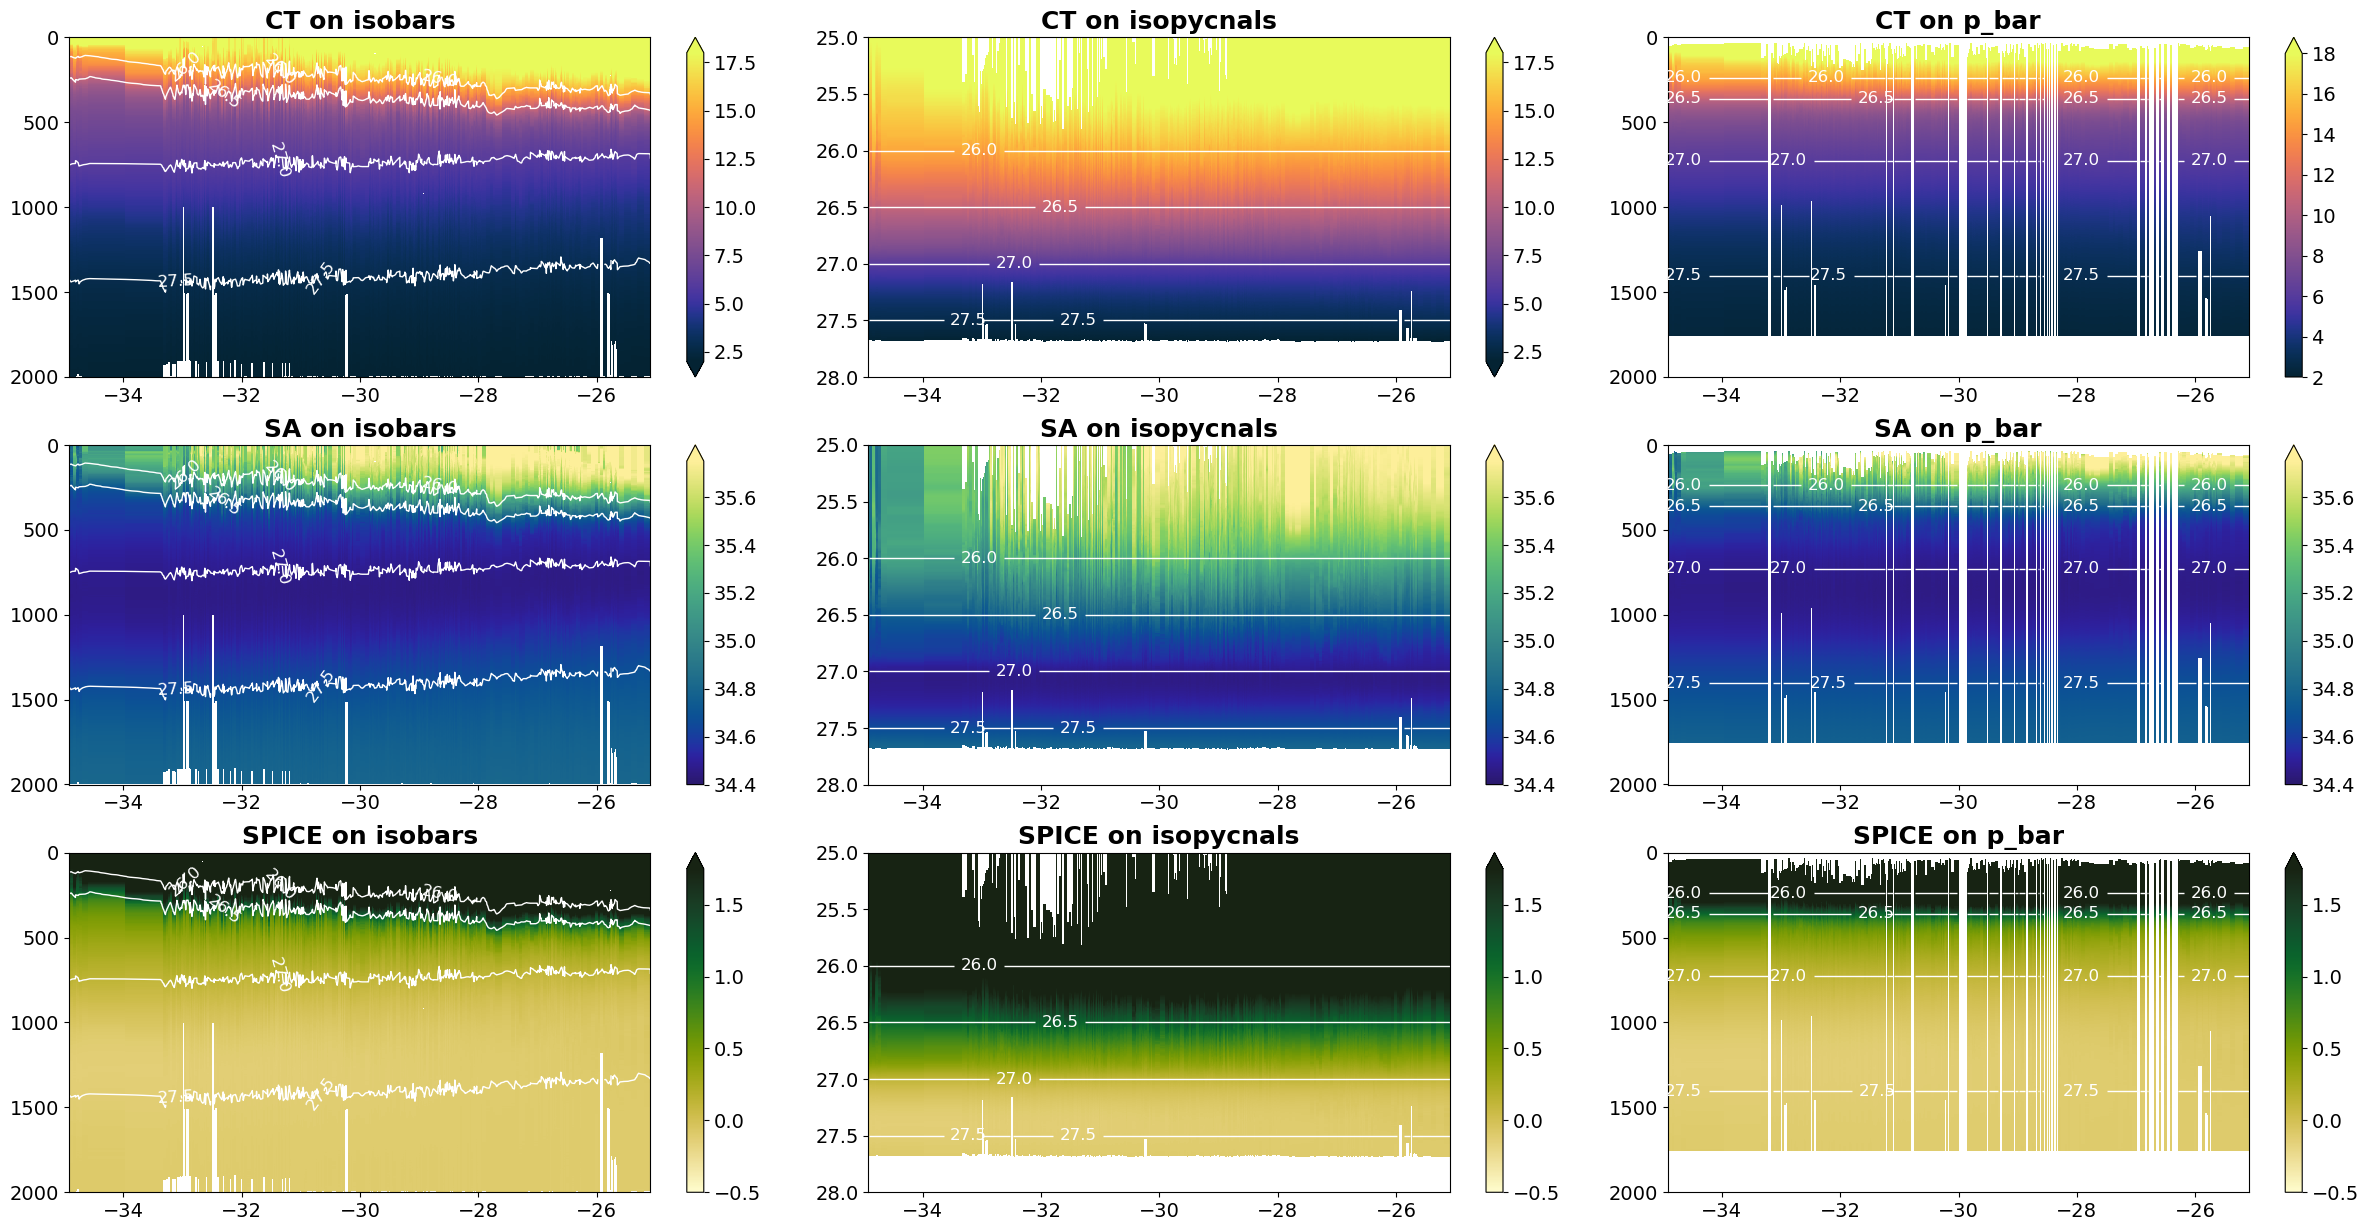

In [57]:
plt.figure(figsize=(30,15))

plt.subplot(331)
section_p.CT.sortby(x).plot(x=x, y='PRESSURE', cmap=ct_cmap, norm=ct_norm, add_labels=False)
contours1 = plt.contour(section_p.LAT.values, section_p.PRESSURE.values, section_p.SIG0.values.T, levels=[26,26.5,27,27.5], colors='white', linewidths=1)
plt.clabel(contours1, inline=True, fontsize=12, fmt="%.1f")
plt.gca().invert_yaxis()
plt.title('CT on isobars')

plt.subplot(332)
section_rho.CT.sortby(x).plot(x=x, y='DENSITY', cmap=ct_cmap, norm=ct_norm, add_labels=False)
contours2 = plt.contour(section_rho.LAT.values, section_rho.DENSITY.values, section_rho.SIG0.values.T, levels=[26,26.5,27,27.5], colors='white', linewidths=1)
plt.clabel(contours2, inline=True, fontsize=12, fmt="%.1f")
plt.ylim(28,25)
plt.title('CT on isopycnals')

plt.subplot(333)
section_pmean.CT.sortby(x).plot(x=x, y='PRESSURE_mean', cmap=ct_cmap, norm=ct_norm, add_labels=False)
contours3 = plt.contour(section_pmean.LAT.values, section_pmean.PRESSURE_mean.values, section_pmean.SIG0.values.T, levels=[26,26.5,27,27.5], colors='white', linewidths=1)
plt.clabel(contours3, inline=True, fontsize=12, fmt="%.1f")
plt.gca().invert_yaxis()
plt.title('CT on p_bar')

plt.subplot(334)
section_p.SA.sortby(x).plot(x=x, y='PRESSURE', cmap=sa_cmap, norm=sa_norm, add_labels=False)
contours1 = plt.contour(section_p.LAT.values, section_p.PRESSURE.values, section_p.SIG0.values.T, levels=[26,26.5,27,27.5], colors='white', linewidths=1)
plt.clabel(contours1, inline=True, fontsize=12, fmt="%.1f")
plt.gca().invert_yaxis()
plt.title('SA on isobars')

plt.subplot(335)
section_rho.SA.sortby(x).plot(x=x, y='DENSITY', cmap=sa_cmap, norm=sa_norm, add_labels=False)
contours2 = plt.contour(section_rho.LAT.values, section_rho.DENSITY.values, section_rho.SIG0.values.T, levels=[26,26.5,27,27.5], colors='white', linewidths=1)
plt.clabel(contours2, inline=True, fontsize=12, fmt="%.1f")
plt.ylim(28,25)
plt.title('SA on isopycnals')

plt.subplot(336)
section_pmean.SA.sortby(x).plot(x=x, y='PRESSURE_mean', cmap=sa_cmap, norm=sa_norm, add_labels=False)
contours3 = plt.contour(section_pmean.LAT.values, section_pmean.PRESSURE_mean.values, section_pmean.SIG0.values.T, levels=[26,26.5,27,27.5], colors='white', linewidths=1)
plt.clabel(contours3, inline=True, fontsize=12, fmt="%.1f")
plt.gca().invert_yaxis()
plt.title('SA on p_bar')

plt.subplot(337)
section_p.SPICE.sortby(x).plot(x=x, y='PRESSURE', cmap=sp_cmap, norm=sp_norm, add_labels=False)
contours1 = plt.contour(section_p.LAT.values, section_p.PRESSURE.values, section_p.SIG0.values.T, levels=[26,26.5,27,27.5], colors='white', linewidths=1)
plt.clabel(contours1, inline=True, fontsize=12, fmt="%.1f")
plt.gca().invert_yaxis()
plt.title('SPICE on isobars')

plt.subplot(338)
section_rho.SPICE.sortby(x).plot(x=x, y='DENSITY', cmap=sp_cmap, norm=sp_norm, add_labels=False)
contours2 = plt.contour(section_rho.LAT.values, section_rho.DENSITY.values, section_rho.SIG0.values.T, levels=[26,26.5,27,27.5], colors='white', linewidths=1)
plt.clabel(contours2, inline=True, fontsize=12, fmt="%.1f")
plt.ylim(28,25)
plt.title('SPICE on isopycnals')

plt.subplot(339)
section_pmean.SPICE.sortby(x).plot(x=x, y='PRESSURE_mean', cmap=sp_cmap, norm=sp_norm, add_labels=False)
contours3 = plt.contour(section_pmean.LAT.values, section_pmean.PRESSURE_mean.values, section_pmean.SIG0.values.T, levels=[26,26.5,27,27.5], colors='white', linewidths=1)
plt.clabel(contours3, inline=True, fontsize=12, fmt="%.1f")
plt.gca().invert_yaxis()
plt.title('SPICE on p_bar')

plt.subplots_adjust(wspace=0.1, hspace=0.2)

## P_mean First: Variance Calculations

### Mesoscale Variance Production

In [ ]:
K_rho_p = xr.open_dataset('/swot/SUM05/amf2288/global_diff.nc').K.drop_vars(['z_l','z_r','lon_l','lon_r','lat_l','lat_r'])

In [ ]:
K_rho_sel_p = K_rho_p.sel(lon_c=section_p.LON.mean(), lat_c=section_p.LAT.mean(), method='nearest')
K_rho_sel_p = K_rho_sel_p.interp(z_c=section_p.PRESSURE)
K_rho_sel_p = K_rho_sel_p.rename({'PRESSURE':'PRESSURE_mean', 'lat_c':'LAT', 'lon_c':'LON'})

In [ ]:
K_rho_sel_p

In [ ]:
lfilt=100
rho_grid = np.arange(21,29,0.0025)
ct_m_pmean = ff.ds_filt_single(section_pmean.rename({'LAT':'lat','LON':'lon'}), lfilt, variable='CT', dim1='PROFILE', dim2='PRESSURE_mean').rename({'lat':'LAT','lon':'LON'})
sa_m_pmean = ff.ds_filt_single(section_pmean.rename({'LAT':'lat','LON':'lon'}), lfilt, variable='SA', dim1='PROFILE', dim2='PRESSURE_mean').rename({'lat':'LAT','lon':'LON'})
sp_m_pmean = ff.ds_filt_single(section_pmean.rename({'LAT':'lat','LON':'lon'}), lfilt, variable='SPICE', dim1='PROFILE', dim2='PRESSURE_mean').rename({'lat':'LAT','lon':'LON'})

In [ ]:
ct_e_pmean = section_pmean.CT - ct_m_pmean
sa_e_pmean = section_pmean.SA - sa_m_pmean
sp_e_pmean = section_pmean.SPICE - sp_m_pmean

In [ ]:
ct_e_z2_pmean = ct_e_pmean.differentiate(coord='PRESSURE_mean')**2
sa_e_z2_pmean = sa_e_pmean.differentiate(coord='PRESSURE_mean')**2
sp_e_z2_pmean = sp_e_pmean.differentiate(coord='PRESSURE_mean')**2

In [ ]:
ct_e_z2_filt_pmean = ff.da_filt_single(ct_e_z2_pmean, lfilt, dim1='PROFILE', dim2='PRESSURE_mean', lat='LAT', lon='LON').rename({'lat':'LAT', 'lon':'LON'})
sa_e_z2_filt_pmean = ff.da_filt_single(sa_e_z2_pmean, lfilt, dim1='PROFILE', dim2='PRESSURE_mean', lat='LAT', lon='LON').rename({'lat':'LAT', 'lon':'LON'})
sp_e_z2_filt_pmean = ff.da_filt_single(sp_e_z2_pmean, lfilt, dim1='PROFILE', dim2='PRESSURE_mean', lat='LAT', lon='LON').rename({'lat':'LAT', 'lon':'LON'})

In [ ]:
ct_var2_pmean = ct_e_z2_filt_pmean
sa_var2_pmean = sa_e_z2_filt_pmean
sp_var2_pmean = sp_e_z2_filt_pmean

In [ ]:
ct2_VPR_pmean = K_rho_sel_p*ct_var2_pmean
sa2_VPR_pmean = K_rho_sel_p*sa_var2_pmean
sp2_VPR_pmean = K_rho_sel_p*sp_var2_pmean

### Microscale Variance Production

In [ ]:
ct_m_z3_pmean = ct_m_pmean.differentiate(coord='PRESSURE_mean')**2
sa_m_z3_pmean = sa_m_pmean.differentiate(coord='PRESSURE_mean')**2
sp_m_z3_pmean = sp_m_pmean.differentiate(coord='PRESSURE_mean')**2

In [ ]:
ct_var3_pmean = ct_m_z3_pmean
sa_var3_pmean = sa_m_z3_pmean
sp_var3_pmean = sp_m_z3_pmean

In [ ]:
ct3_VPR_pmean = K_rho_sel_p*ct_var3_pmean
sa3_VPR_pmean = K_rho_sel_p*sa_var3_pmean
sp3_VPR_pmean = K_rho_sel_p*sp_var3_pmean

## P_mean Last: Variance Calculations

In [ ]:
def interp_to_rho(rho_profile, var_profile, rho_grid, flag='group'):
    
    valid = ~np.isnan(rho_profile) & ~np.isnan(var_profile)
    rho_nonan = rho_profile[valid]
    var_nonan = var_profile[valid]

    if len(rho_nonan) < 3 or len(var_nonan) < 3:
        return np.full_like(rho_grid, np.nan)

    if flag == 'group':
        _, idx = np.unique(rho_nonan, return_index=True)
        rho_nonan = rho_nonan[idx]
        var_nonan = var_nonan[idx]

    fvar = interpolate.PchipInterpolator(rho_nonan, var_nonan, extrapolate=False)
    return fvar(rho_grid)

In [ ]:
def get_ds_rho(ds_z, da_SIG0, rho_grid, variables, dim1='PROFILE', dim2='PRESSURE'):

    xrs = []
    rho_size = rho_grid.size
    
    for var in variables:
        var_interp = xr.apply_ufunc(interp_to_rho, da_SIG0, ds_z[var],
            input_core_dims=[[dim2], [dim2]],
            output_core_dims=[['rho_grid']],
            dask_gufunc_kwargs={'output_sizes': {'rho_grid': rho_size}},
            vectorize=True,
            dask='parallelized',
            kwargs={'rho_grid': rho_grid},
            output_dtypes=[ds_z[var].dtype])
        print(f'Completed comp for {var}')
        var_interp = xr.DataArray(
            data=var_interp.data,
            dims=[dim1, 'rho_grid'],
            coords={'rho_grid': rho_grid, dim1: ds_z[dim1]},
            name=var)
        xrs.append(var_interp)
        print(f'Completed {var}')
    
    ds_rho = xr.merge(xrs)
    print(f'Completed merge')
    #ds_rho = ds_rho.assign_coords(TIME      =(dim1, ds_z.TIME.data))
    ds_rho = ds_rho.assign_coords(LAT  =(dim1, ds_z.LAT.data))
    ds_rho = ds_rho.assign_coords(LON = (dim1, ds_z.LON.data))
    
    return ds_rho

### Mesoscale Variance Production

In [ ]:
K_rho_rho = xr.open_dataset('/swot/SUM05/amf2288/var-boxes/K_rho_3dx.nc').K_filt_3dx.rename({'lon':'LON','lat':'LAT','density':'DENSITY'})

In [ ]:
K_rho_sel_rho = K_rho_rho.sel(LON=section_rho.LON.mean(), LAT=section_rho.LAT.mean(), method='nearest')

In [ ]:
K_rho_sel_rho

In [ ]:
ct_m_p = ff.ds_filt_single(section_p.rename({'LAT':'lat','LON':'lon'}), lfilt, variable='CT', dim1='PROFILE', dim2='PRESSURE').rename({'lat':'LAT','lon':'LON'})
sa_m_p = ff.ds_filt_single(section_p.rename({'LAT':'lat','LON':'lon'}), lfilt, variable='SA', dim1='PROFILE', dim2='PRESSURE').rename({'lat':'LAT','lon':'LON'})
sp_m_p = ff.ds_filt_single(section_p.rename({'LAT':'lat','LON':'lon'}), lfilt, variable='SPICE', dim1='PROFILE', dim2='PRESSURE').rename({'lat':'LAT','lon':'LON'})

In [ ]:
ct_e_p = section_p.CT - ct_m_p
sa_e_p = section_p.SA - sa_m_p
sp_e_p = section_p.SPICE - sp_m_p

In [ ]:
ct_e_z2_p = ct_e_p.differentiate(coord='PRESSURE')**2
sa_e_z2_p = sa_e_p.differentiate(coord='PRESSURE')**2
sp_e_z2_p = sp_e_p.differentiate(coord='PRESSURE')**2

In [ ]:
ct_e_z2_filt_p = ff.da_filt_single(ct_e_z2_p, lfilt, dim1='PROFILE', dim2='PRESSURE', lat='LAT', lon='LON').rename({'lat':'LAT', 'lon':'LON'})
sa_e_z2_filt_p = ff.da_filt_single(sa_e_z2_p, lfilt, dim1='PROFILE', dim2='PRESSURE', lat='LAT', lon='LON').rename({'lat':'LAT', 'lon':'LON'})
sp_e_z2_filt_p = ff.da_filt_single(sp_e_z2_p, lfilt, dim1='PROFILE', dim2='PRESSURE', lat='LAT', lon='LON').rename({'lat':'LAT', 'lon':'LON'})

In [ ]:
ct_e_z2_filt_p.name = 'ct_e_z2_filt_p'
ct_e_z2_filt_p = ct_e_z2_filt_p.to_dataset()

sa_e_z2_filt_p.name = 'sa_e_z2_filt_p'
sa_e_z2_filt_p = sa_e_z2_filt_p.to_dataset()

sp_e_z2_filt_p.name = 'sp_e_z2_filt_p'
sp_e_z2_filt_p = sp_e_z2_filt_p.to_dataset()

In [ ]:
ct_e_z2_filt_p

In [ ]:
ct_var2_rho = get_ds_rho(ct_e_z2_filt_p, section_p.SIG0, rho_grid, ct_e_z2_filt_p, dim1='PROFILE', dim2='PRESSURE').rename({'rho_grid':'DENSITY'})
sa_var2_rho = get_ds_rho(sa_e_z2_filt_p, section_p.SIG0, rho_grid, sa_e_z2_filt_p, dim1='PROFILE', dim2='PRESSURE').rename({'rho_grid':'DENSITY'})
sp_var2_rho = get_ds_rho(sp_e_z2_filt_p, section_p.SIG0, rho_grid, sp_e_z2_filt_p, dim1='PROFILE', dim2='PRESSURE').rename({'rho_grid':'DENSITY'})

In [ ]:
ct2_VPR_rho = K_rho_sel_rho*ct_var2_rho
sa2_VPR_rho = K_rho_sel_rho*sa_var2_rho
sp2_VPR_rho = K_rho_sel_rho*sp_var2_rho

In [ ]:
ct2_VPR_rho['PRES'] = (('PROFILE','DENSITY'), section_rho.PRES.data)
sa2_VPR_rho['PRES'] = (('PROFILE','DENSITY'), section_rho.PRES.data)
sp2_VPR_rho['PRES'] = (('PROFILE','DENSITY'), section_rho.PRES.data)

In [ ]:
ct_e_z2_filt_p

In [ ]:
ct2_VPR_rho_pmean = get_ds_pmean(ct2_VPR_rho, np.arange(0,2001,2), ct_e_z2_filt_p, dim1='PROFILE', dim2='DENSITY').ct_e_z2_filt_p.rename({'pmean_grid':'PRESSURE_mean'})
sa2_VPR_rho_pmean = get_ds_pmean(sa2_VPR_rho, np.arange(0,2001,2), sa_e_z2_filt_p, dim1='PROFILE', dim2='DENSITY').sa_e_z2_filt_p.rename({'pmean_grid':'PRESSURE_mean'})
sp2_VPR_rho_pmean = get_ds_pmean(sp2_VPR_rho, np.arange(0,2001,2), sp_e_z2_filt_p, dim1='PROFILE', dim2='DENSITY').sp_e_z2_filt_p.rename({'pmean_grid':'PRESSURE_mean'})

### Microscale Variance Production

In [ ]:
ct_m_z3_p = ct_m_p.differentiate(coord='PRESSURE')**2
sa_m_z3_p = sa_m_p.differentiate(coord='PRESSURE')**2
sp_m_z3_p = sp_m_p.differentiate(coord='PRESSURE')**2

In [ ]:
ct_m_z3_p.name = 'ct_m_z3_p'
ct_m_z3_p = ct_m_z3_p.to_dataset()

sa_m_z3_p.name = 'sa_m_z3_p'
sa_m_z3_p = sa_m_z3_p.to_dataset()

sp_m_z3_p.name = 'sp_m_z3_p'
sp_m_z3_p = sp_m_z3_p.to_dataset()

In [ ]:
ct_var3_rho = get_ds_rho(ct_m_z3_p, section_p.SIG0, rho_grid, ct_m_z3_p, dim1='PROFILE', dim2='PRESSURE').rename({'rho_grid':'DENSITY'})
sa_var3_rho = get_ds_rho(sa_m_z3_p, section_p.SIG0, rho_grid, sa_m_z3_p, dim1='PROFILE', dim2='PRESSURE').rename({'rho_grid':'DENSITY'})
sp_var3_rho = get_ds_rho(sp_m_z3_p, section_p.SIG0, rho_grid, sp_m_z3_p, dim1='PROFILE', dim2='PRESSURE').rename({'rho_grid':'DENSITY'})

In [ ]:
ct3_VPR_rho = K_rho_sel_rho*ct_var3_rho
sa3_VPR_rho = K_rho_sel_rho*sa_var3_rho
sp3_VPR_rho = K_rho_sel_rho*sp_var3_rho

In [ ]:
ct3_VPR_rho['PRES'] = (('PROFILE','DENSITY'), section_rho.PRES.data)
sa3_VPR_rho['PRES'] = (('PROFILE','DENSITY'), section_rho.PRES.data)
sp3_VPR_rho['PRES'] = (('PROFILE','DENSITY'), section_rho.PRES.data)

In [ ]:
ct3_VPR_rho_pmean = get_ds_pmean(ct3_VPR_rho, np.arange(0,2001,2), ct_m_z3_p, dim1='PROFILE', dim2='DENSITY').ct_m_z3_p.rename({'pmean_grid':'PRESSURE_mean'})
sa3_VPR_rho_pmean = get_ds_pmean(sa3_VPR_rho, np.arange(0,2001,2), sa_m_z3_p, dim1='PROFILE', dim2='DENSITY').sa_m_z3_p.rename({'pmean_grid':'PRESSURE_mean'})
sp3_VPR_rho_pmean = get_ds_pmean(sp3_VPR_rho, np.arange(0,2001,2), sp_m_z3_p, dim1='PROFILE', dim2='DENSITY').sp_m_z3_p.rename({'pmean_grid':'PRESSURE_mean'})

## Plots! :)

In [ ]:
x = 'LAT'

In [ ]:
plt.figure(figsize=(30,15))

cmap    = cmo.matter_r
ct_norm = colors.LogNorm(vmin=1e-11,vmax=1e-8)
sa_norm = colors.LogNorm(vmin=1e-13,vmax=1e-10)
sp_norm = colors.LogNorm(vmin=1e-13,vmax=1e-10)

plt.subplot(231)
ct2_VPR_pmean.sortby(x).plot(x=x, y='PRESSURE_mean', cmap=cmap, norm=ct_norm, add_labels=False)
plt.ylim(375,1875)
plt.ylabel('P_bar [m]')
plt.gca().invert_yaxis()
plt.title('MesoVP-CT, calculations on pmean')

plt.subplot(232)
sa2_VPR_pmean.sortby(x).plot(x=x, y='PRESSURE_mean', cmap=cmap, norm=sa_norm, add_labels=False)
plt.ylim(375,1875)
plt.gca().invert_yaxis()
plt.title('MesoVP-SA, calculations on pmean')

plt.subplot(233)
sp2_VPR_pmean.sortby(x).plot(x=x, y='PRESSURE_mean', cmap=cmap, norm=sp_norm, add_labels=False)
plt.ylim(375,1875)
plt.gca().invert_yaxis()
plt.title('MesoVP-SPICE, calculations on pmean')

plt.subplot(234)
ct2_VPR_rho_pmean.sortby(x).plot(x=x, y='PRESSURE_mean', cmap=cmap, norm=ct_norm, add_labels=False)
plt.ylim(375,1875)
plt.ylabel('P_bar [m]')
plt.gca().invert_yaxis()
plt.title('MesoVP-CT, calculations on p')

plt.subplot(235)
sa2_VPR_rho_pmean.sortby(x).plot(x=x, y='PRESSURE_mean', cmap=cmap, norm=sa_norm, add_labels=False)
plt.ylim(375,1875)
plt.gca().invert_yaxis()
plt.title('MesoVP-SA, calculations on p')

plt.subplot(236)
sp2_VPR_rho_pmean.sortby(x).plot(x=x, y='PRESSURE_mean', cmap=cmap, norm=sp_norm, add_labels=False)
plt.ylim(375,1875)
plt.gca().invert_yaxis()
plt.title('MesoVP-SPICE, calculations on p')

plt.subplots_adjust(wspace=0.2, hspace=0.25)

In [ ]:
plt.figure(figsize=(30,15))

cmap    = cmo.matter_r
ct_norm = colors.LogNorm(vmin=1e-11,vmax=1e-8)
sa_norm = colors.LogNorm(vmin=1e-13,vmax=1e-10)
sp_norm = colors.LogNorm(vmin=1e-13,vmax=1e-10)

plt.subplot(231)
ct3_VPR_pmean.sortby(x).plot(x=x, y='pmean', cmap=cmap, norm=ct_norm, add_labels=False)
plt.ylim(375,1875)
plt.ylabel('P_bar [m]')
plt.gca().invert_yaxis()
plt.title('MicroVP-CT, calculations on pmean')

plt.subplot(232)
sa3_VPR_pmean.sortby(x).plot(x=x, y='pmean', cmap=cmap, norm=sa_norm, add_labels=False)
plt.ylim(375,1875)
plt.gca().invert_yaxis()
plt.title('MicroVP-SA, calculations on pmean')

plt.subplot(233)
sp3_VPR_pmean.sortby(x).plot(x=x, y='pmean', cmap=cmap, norm=sp_norm, add_labels=False)
plt.ylim(375,1875)
plt.gca().invert_yaxis()
plt.title('MicroVP-SPICE, calculations on pmean')

plt.subplot(234)
ct3_VPR_rho_pmean.sortby(x).plot(x=x, y='pmean', cmap=cmap, norm=ct_norm, add_labels=False)
plt.ylim(375,1875)
plt.ylabel('P_bar [m]')
plt.gca().invert_yaxis()
plt.title('MicroVP-CT, calculations on p')

plt.subplot(235)
sa3_VPR_rho_pmean.sortby(x).plot(x=x, y='pmean', cmap=cmap, norm=sa_norm, add_labels=False)
plt.ylim(375,1875)
plt.gca().invert_yaxis()
plt.title('MicroVP-SA, calculations on p')

plt.subplot(236)
sp3_VPR_rho_pmean.sortby(x).plot(x=x, y='pmean', cmap=cmap, norm=sp_norm, add_labels=False)
plt.ylim(375,1875)
plt.gca().invert_yaxis()
plt.title('MicroVP-SPICE, calculations on p')

plt.subplots_adjust(wspace=0.2, hspace=0.25)

In [ ]:
ct_meso_frac_pmean = ct2_VPR_pmean.mean('PROFILE') / (ct2_VPR_pmean.mean('PROFILE')+ct3_VPR_pmean.mean('PROFILE'))
ct_meso_frac_rho_pmean = ct2_VPR_rho_pmean.mean('PROFILE') / (ct2_VPR_rho_pmean.mean('PROFILE')+ct3_VPR_rho_pmean.mean('PROFILE'))

sa_meso_frac_pmean = sa2_VPR_pmean.mean('PROFILE') / (sa2_VPR_pmean.mean('PROFILE')+sa3_VPR_pmean.mean('PROFILE'))
sa_meso_frac_rho_pmean = sa2_VPR_rho_pmean.mean('PROFILE') / (sa2_VPR_rho_pmean.mean('PROFILE')+sa3_VPR_rho_pmean.mean('PROFILE'))

In [ ]:
ct2_VPR_pf = xr.open_dataset('/swot/SUM05/amf2288/box_ct2_VPR.nc')
ct3_VPR_pf = xr.open_dataset('/swot/SUM05/amf2288/box_ct3_VPR.nc')
ct_meso_frac_pf = (ct2_VPR_pf.mean('PROFILE') / (ct2_VPR_pf.mean('PROFILE')+ct3_VPR_pf.mean('PROFILE'))).__xarray_dataarray_variable__.rename({'PRESSURE':'PRESSURE_mean'})

sa2_VPR_pf = xr.open_dataset('/swot/SUM05/amf2288/box_sa2_VPR.nc')
sa3_VPR_pf = xr.open_dataset('/swot/SUM05/amf2288/box_sa3_VPR.nc')
sa_meso_frac_pf = (sa2_VPR_pf.mean('PROFILE') / (sa2_VPR_pf.mean('PROFILE')+sa3_VPR_pf.mean('PROFILE'))).__xarray_dataarray_variable__.rename({'PRESSURE':'PRESSURE_mean'})

In [ ]:
plt.figure()
ct_meso_frac_pmean.plot.line(y='PRESSURE_mean',label='calc on p_mean, CT',color='tab:blue')
ct_meso_frac_rho_pmean.plot.line(y='PRESSURE_mean',label='calc on p_interp, CT',color='tab:blue', linestyle='--')
ct_meso_frac_pf.plot.line(y='PRESSURE_mean',label='polynomial fit, CT', color='tab:blue', linestyle=':')
sa_meso_frac_pmean.plot.line(y='PRESSURE_mean',label='calc on p_mean, SA',color='tab:orange')
sa_meso_frac_rho_pmean.plot.line(y='PRESSURE_mean',label='calc on p_interp, SA',color='tab:orange', linestyle='--')
sa_meso_frac_pf.plot.line(y='PRESSURE_mean',label='polynomial fit, SA', color='tab:orange', linestyle=':')
plt.legend()
plt.gca().invert_yaxis()
plt.title('Mesocale Fraction of Variance Production')

In [ ]:
sa2_VPR_pmean.mean('PROFILE').plot(y='PRESSURE_mean',label='meso, p_mean')
sa2_VPR_rho_pmean.mean('PROFILE').plot(y='PRESSURE_mean',label='meso, p_interp',linestyle='--',color='tab:blue')
sa2_VPR_pf.__xarray_dataarray_variable__.mean('PROFILE').rename({'PRESSURE':'PRESSURE_mean'}).plot(y='PRESSURE_mean',label='meso, polyfit',linestyle=':',color='tab:blue')

sa3_VPR_pmean.mean('PROFILE').plot(y='PRESSURE_mean',label='micro, p_mean')
sa3_VPR_rho_pmean.mean('PROFILE').plot(y='PRESSURE_mean',label='micro, p_interp',linestyle='--',color='tab:orange')
sa3_VPR_pf.__xarray_dataarray_variable__.mean('PROFILE').rename({'PRESSURE':'PRESSURE_mean'}).plot(y='PRESSURE_mean',label='micro, polyfit',linestyle=':',color='tab:orange')
plt.xscale('log')
plt.legend()
plt.gca().invert_yaxis()
plt.title('Microscale Variance Production')

## Individual Profiles

In [ ]:
section_p

In [ ]:
plt.figure(figsize=(10,12))
prof=300

plt.subplot(231)
section_p.CT.isel(prof=prof).plot(y='depth', label='T[p]', linewidth=2)
section_pmean.CT.isel(prof=prof).plot(y='pmean', label='T[rho]', linewidth=2)
ct_m_p.isel(prof=prof).plot(y='depth', linestyle='--', linewidth=1, color='k')
ct_m_pmean.isel(prof=prof).plot(y='pmean', label='T_m', linestyle='--', linewidth=1, color='k')
plt.gca().invert_yaxis()
plt.legend()
plt.title(f'CT, profile: {prof}')

plt.subplot(232)
section_p.SA.isel(prof=prof).plot(y='depth', label='T[p]')
section_pmean.SA.isel(prof=prof).plot(y='pmean', label='T[rho]')
sa_m_p.isel(prof=prof).plot(y='depth', linestyle='--', linewidth=1, color='k')
sa_m_pmean.isel(prof=prof).plot(y='pmean', label='T_m', linestyle='--', linewidth=1, color='k')
plt.gca().invert_yaxis()
plt.ylabel('')
plt.title('SA')

plt.subplot(233)
section_p.SPICE.isel(prof=prof).plot(y='depth', label='T[p]')
section_pmean.SPICE.isel(prof=prof).plot(y='pmean', label='T[rho]')
sp_m_p.isel(prof=prof).plot(y='depth', linestyle='--', linewidth=1, color='k')
sp_m_pmean.isel(prof=prof).plot(y='pmean', label='T_m', linestyle='--', linewidth=1, color='k')
plt.gca().invert_yaxis()
plt.ylabel('')
plt.title('SPICE')

plt.subplot(234)
ct_e_p.isel(prof=prof).plot(y='depth', label='calculated on p')
ct_e_pmean.isel(prof=prof).plot(y='pmean', label='calculated on p')
plt.gca().invert_yaxis()
plt.legend()
plt.title('CT_e')

plt.subplot(235)
sa_e_p.isel(prof=prof).plot(y='depth', label='calculated on p')
sa_e_pmean.isel(prof=prof).plot(y='pmean', label='calculated on pmean')
plt.gca().invert_yaxis()
plt.ylabel('')
plt.title('SA_e')

plt.subplot(236)
sp_e_p.isel(prof=prof).plot(y='depth', label='calculated on p')
sp_e_pmean.isel(prof=prof).plot(y='pmean', label='calculated on p')
plt.gca().invert_yaxis()
plt.ylabel('')
plt.title('SPICE_e')

plt.subplots_adjust(wspace=0.3)

# Visualizing section_rho

In [ ]:
pmean_smooth = section_rho.PRES.mean('prof').rolling({'density':50}, center=True).mean()
density_min = pmean_smooth.idxmin(dim="density").item()
density_max = pmean_smooth.idxmax(dim="density").item()

print("Density at min:", density_min)
print("Density at max:", density_max)

In [ ]:
# Find indices of min/max along depth for each profile
imin = section_p.SIG0.argmin(dim="depth")
imax = section_p.SIG0.argmax(dim="depth")

# Get the density values at those indices
density_min_prof = section_p.SIG0.isel(depth=imin)
density_max_prof = section_p.SIG0.isel(depth=imax)

# Get the latitude (or x-coordinate) for plotting
latitudes = section_p.LATITUDE

In [ ]:
plt.figure(figsize=(15,5))

section_rho.CT.sortby(x).plot(x=x, y='density', cmap=ct_cmap, norm=ct_norm, add_labels=False)
plt.axhline(density_min,color='r',linestyle='--',label='Reference min/max')
plt.axhline(density_max,color='r',linestyle='--')
plt.scatter(latitudes, density_min_prof, color='red', marker='o', s=10, label='Min density')
plt.scatter(latitudes, density_max_prof, color='blue', marker='o', s=10, label='Max density')
contours2 = plt.contour(section_rho.LATITUDE.values, section_rho.density.values,
                        section_rho.SIG0.values.T, levels=[26,26.5,27,27.5],
                        colors='white', linewidths=1)
plt.clabel(contours2, inline=True, fontsize=12, fmt="%.1f")
plt.ylim(28,22.5)
plt.title('CT on isopycnals')
plt.legend()

In [ ]:
#profiles where density exceeds bounds of reference profile
mask_min = density_min_prof < density_min
mask_max = density_max_prof > density_max
density_mask = mask_min | mask_max
#profiles with densities outside reference profile
ext_profiles = density_mask.where(density_mask, drop=True).prof

mask_all_nan = section_pmean.CT.isnull().all(dim="pmean")
nan_profiles = section_pmean.prof.where(mask_all_nan, drop=True)

In [ ]:
print('Number of profiles less than the minimum density:', mask_min.sum().values)
print('Number of profiles more than the maximum density:', mask_max.sum().values)
print('Total number of profiles:', len(section_p.prof))

In [ ]:
print('Number of profiles which are entirely nan:', mask_all_nan.sum().values)

In [ ]:
print("Number all nan and outside reference:", ext_profiles.where(ext_profiles.isin(nan_profiles), drop=True).size)

## Investigating delta_p

In [ ]:
dp = section_rho.dropna(dim='density').PRES.diff('density')

In [ ]:
print(f'Max dp: {dp.max().values}')
print(f'Min dp: {dp.min().values}')

The minimum dp is negative?????????????? How is this possible

Ohhhh it must be because I haven't sorted anything

ERROR! Session/line number was not unique in database. History logging moved to new session 1212


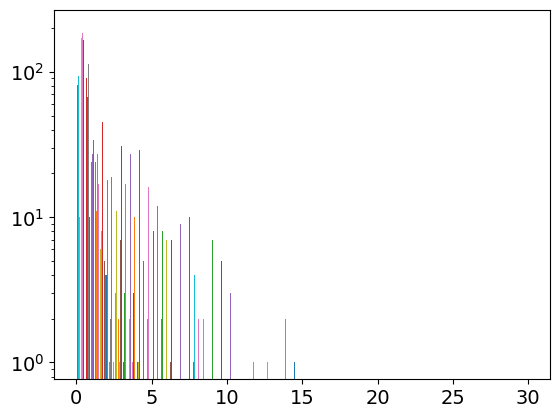

In [29]:
plt.hist(dp,bins=np.linspace(0,30,100))
plt.yscale('log')

## Sorting by density and reindexing

In [48]:
# Get sorting order along depth for each profile
order = section_p.SIG0.values.argsort(axis=1)

# Sort SIG0 and depth using numpy
sorted_sig0 = np.take_along_axis(section_p.SIG0.values, order, axis=1)
sorted_depth = np.take_along_axis(section_p.depth.values[np.newaxis, :], order, axis=1)

# Wrap back into DataArrays with LATITUDE and LONGITUDE attached
sorted_sig0_da = xr.DataArray(
    sorted_sig0,
    dims=("prof", "depth"),
    coords={
        "prof": section_p.prof,
        "depth": np.arange(section_p.depth.size),  # new sorted index
        "LATITUDE": ("prof", section_p.LATITUDE.values),
        "LONGITUDE": ("prof", section_p.LONGITUDE.values),
    },
    name="SIG0_sorted"
)

sorted_depth_da = xr.DataArray(
    sorted_depth,
    dims=("prof", "depth"),
    coords={
        "prof": section_p.prof,
        "depth": np.arange(section_p.depth.size),
        "LATITUDE": ("prof", section_p.LATITUDE.values),
        "LONGITUDE": ("prof", section_p.LONGITUDE.values),
    },
    name="depth_sorted"
)

Sorting: currently all nans are moved to the bottom of the profile. Instead it should iterate thorugh each profile and:
- remove all nan values from the top and bottom
- resort densities to be increasing with depth
- pad with nans at the top and bottom

potential density referenced to the surface might be causing problems here. instead look at
- potential density referenced to 1000 m
- neutral density (gsw) --> this is preferable based on what's in the literature

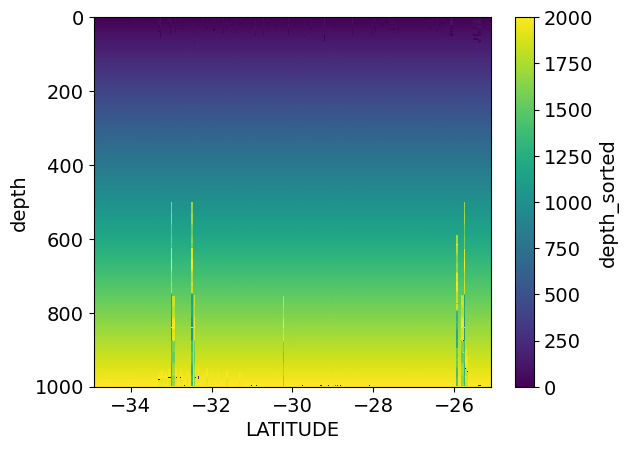

In [53]:
sorted_depth_da.sortby('LATITUDE').plot(x='LATITUDE', y='depth')
plt.gca().invert_yaxis()

In [55]:
# Original SIG0 values
orig_sig0 = section_p.SIG0.values

# Sorted SIG0 values (from your sig0_da)
sorted_sig0 = sorted_sig0_da.values

# Boolean mask: True if the entire profile is identical before and after sorting
same_profiles = np.all(orig_sig0 == sorted_sig0, axis=1)

# Count how many changed
num_changed = np.sum(~same_profiles)
num_unchanged = np.sum(same_profiles)

print("Profiles unchanged:", num_unchanged)
print("Profiles changed:", num_changed)

Profiles unchanged: 0
Profiles changed: 409


In [60]:
# Step 1: get sorting order along depth for each profile
order = section_p.SIG0.values.argsort(axis=1)  # shape (prof, depth)

# Step 2: reorder every variable consistently
sorted_vars = {}
for var in section_p.data_vars:
    arr = section_p[var].values
    # reorder along depth using take_along_axis
    sorted_arr = np.take_along_axis(arr, order, axis=1)
    sorted_vars[var] = (("prof", "depth_sorted"), sorted_arr)

# Step 3: create new depth coordinate
depth_sorted = np.arange(0, 2000+1, 2)  # 0,2,...,2000 (length 1001)

# Step 4: add old reordered depth as a variable
old_depth_sorted = np.take_along_axis(
    section_p.depth.values[np.newaxis, :], order, axis=1
)

# Step 5: build new dataset
sorted_ds = xr.Dataset(
    data_vars=sorted_vars,
    coords={
        "prof": section_p.prof,
        "depth_sorted": depth_sorted,
        "LATITUDE": ("prof", section_p.LATITUDE.values),
        "LONGITUDE": ("prof", section_p.LONGITUDE.values),
    }
)

# Add old depth as a variable
sorted_ds["depth_original_sorted"] = (("prof", "depth_sorted"), old_depth_sorted)


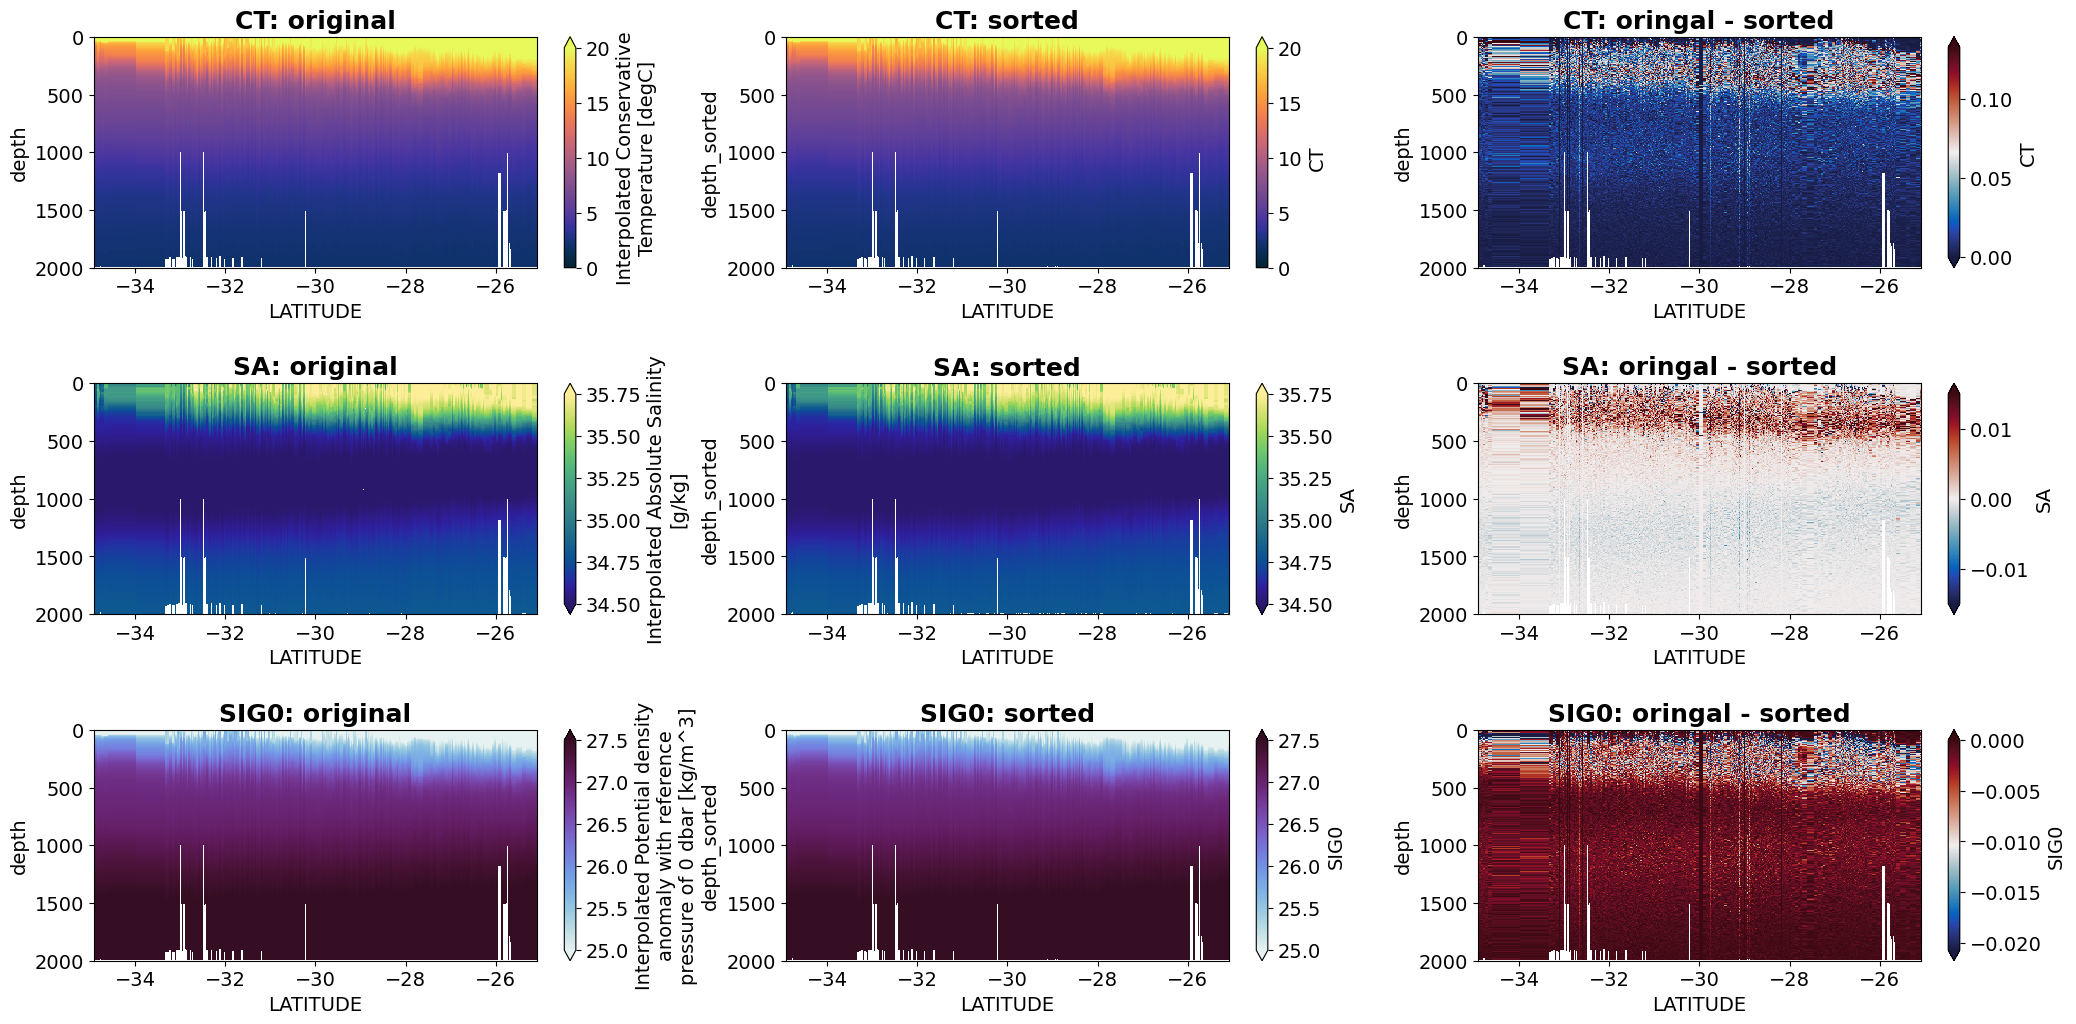

In [80]:
plt.figure(figsize=(25,12))

plt.subplot(331)
section_p.CT.sortby(x).plot(x=x, y='depth',cmap=cmo.thermal,vmin=0,vmax=20)
plt.gca().invert_yaxis()
plt.title('CT: original')

plt.subplot(332)
sorted_ds.CT.sortby(x).plot(x=x, y='depth_sorted',cmap=cmo.thermal,vmin=0,vmax=20)
plt.gca().invert_yaxis()
plt.title('CT: sorted')

plt.subplot(333)
(section_p.CT-sorted_ds.rename({'depth_sorted':'depth'}).CT).sortby(x).plot(x=x, y='depth',cmap=cmo.balance,robust=True)
plt.gca().invert_yaxis()
plt.title('CT: oringal - sorted')

plt.subplot(334)
section_p.SA.sortby(x).plot(x=x, y='depth',cmap=cmo.haline,vmin=34.5,vmax=35.75)
plt.gca().invert_yaxis()
plt.title('SA: original')

plt.subplot(335)
sorted_ds.SA.sortby(x).plot(x=x, y='depth_sorted',cmap=cmo.haline,vmin=34.5,vmax=35.75)
plt.gca().invert_yaxis()
plt.title('SA: sorted')

plt.subplot(336)
(section_p.SA-sorted_ds.rename({'depth_sorted':'depth'}).SA).sortby(x).plot(x=x, y='depth',cmap=cmo.balance,robust=True)
plt.gca().invert_yaxis()
plt.title('SA: oringal - sorted')

plt.subplot(337)
section_p.SIG0.sortby(x).plot(x=x, y='depth',cmap=cmo.dense,vmin=25,vmax=27.5)
plt.gca().invert_yaxis()
plt.title('SIG0: original')

plt.subplot(338)
sorted_ds.SIG0.sortby(x).plot(x=x, y='depth_sorted',cmap=cmo.dense,vmin=25,vmax=27.5)
plt.gca().invert_yaxis()
plt.title('SIG0: sorted')

plt.subplot(339)
(section_p.SIG0-sorted_ds.rename({'depth_sorted':'depth'}).SIG0).sortby(x).plot(x=x, y='depth',cmap=cmo.balance,robust=True)
plt.gca().invert_yaxis()
plt.title('SIG0: oringal - sorted')

plt.subplots_adjust(wspace=0.25, hspace=0.5);

In [90]:
orig = section_p.SIG0.values        # shape (prof, depth)
sorted_ = sorted_ds.SIG0.values            # shape (prof, depth)

# Max absolute difference per profile
max_diff = np.nanmax(np.abs(orig - sorted_), axis=1)

# RMS difference per profile
rms_diff = np.sqrt(np.nanmean((orig - sorted_)**2, axis=1))

In [91]:
# Get profile IDs
prof_ids = section_p.prof.values

# Sort by max_diff
order_max = np.argsort(-max_diff)   # negative for descending
profiles_by_max = prof_ids[order_max]
max_diff_sorted = max_diff[order_max]

# Sort by rms_diff
order_rms = np.argsort(-rms_diff)
profiles_by_rms = prof_ids[order_rms]
rms_diff_sorted = rms_diff[order_rms]

In [94]:
# Top 10 profiles by max_diff
for pid, diff in zip(profiles_by_max[:10], max_diff_sorted[:10]):
    print(f"Profile {pid}: max_diff={diff:.3f}")

# Top 10 profiles by rms_diff
for pid, diff in zip(profiles_by_rms[:10], rms_diff_sorted[:10]):
    print(f"Profile {pid}: rms_diff={diff:.3f}")

Profile 1983876: max_diff=0.428
Profile 1264549: max_diff=0.424
Profile 1264406: max_diff=0.400
Profile 1264573: max_diff=0.377
Profile 1264397: max_diff=0.368
Profile 1983703: max_diff=0.352
Profile 1983011: max_diff=0.349
Profile 1984183: max_diff=0.340
Profile 1264410: max_diff=0.337
Profile 1983869: max_diff=0.334
Profile 1264406: rms_diff=0.026
Profile 1264225: rms_diff=0.018
Profile 1983876: rms_diff=0.017
Profile 1983869: rms_diff=0.017
Profile 1264397: rms_diff=0.017
Profile 1264549: rms_diff=0.017
Profile 1984189: rms_diff=0.016
Profile 1264573: rms_diff=0.016
Profile 1264383: rms_diff=0.016
Profile 1983700: rms_diff=0.016


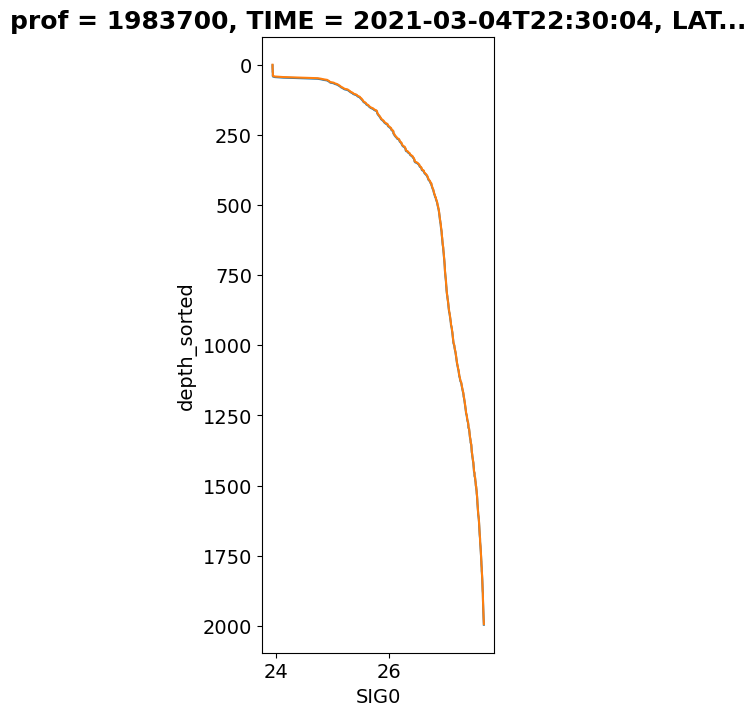

In [96]:
num=1983700

plt.figure(figsize=(3,8))
section_p.SIG0.sel(prof=num).plot(y='depth')
sorted_ds.SIG0.sel(prof=num).plot(y='depth_sorted')
plt.gca().invert_yaxis()

In [111]:
sorted_rho = get_ds_rho(sorted_ds, sorted_ds.SIG0, np.arange(21,29,0.0025), ['CT','SA','SIG0','SPICE','PRES','depth_original_sorted','depth_sorted'], dim1='prof', dim2='depth_sorted')

Completed comp for CT
Completed CT
Completed comp for SA
Completed SA
Completed comp for SIG0
Completed SIG0
Completed comp for SPICE
Completed SPICE
Completed comp for PRES
Completed PRES


/home.ufs/amf2288/miniforge3/envs/Argo_Feb_25/lib/python3.12/site-packages/numpy/lib/function_base.py:2506: RuntimeWarning: invalid value encountered in cast
  output[index] = result


Completed comp for depth_original_sorted
Completed depth_original_sorted
Completed comp for depth_sorted
Completed depth_sorted
Completed merge


In [113]:
sorted_pmean = get_ds_pmean(sorted_rho, np.linspace(0, 2000, 1001), ['CT','SA','SIG0','SPICE','PRES'], dim1='prof')

Completed comp for CT
Completed CT
Completed comp for SA
Completed SA
Completed comp for SIG0
Completed SIG0
Completed comp for SPICE
Completed SPICE
Completed comp for PRES
Completed PRES
Completed merge


Text(0.5, 1.0, 'sorted density')

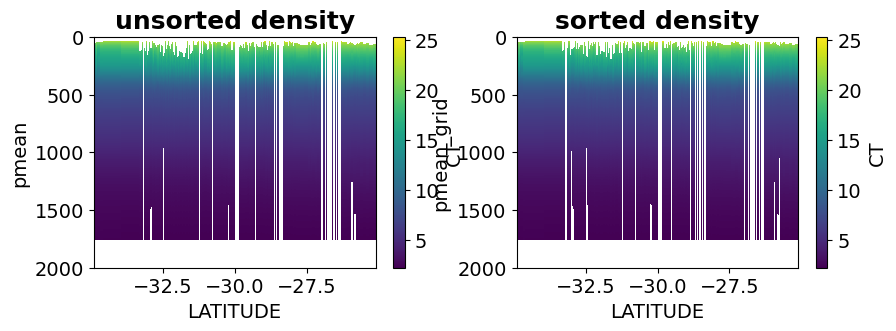

In [120]:
plt.figure(figsize=(10,3))

plt.subplot(121)
section_pmean.CT.sortby(x).plot(x=x, y='pmean')
plt.gca().invert_yaxis()
plt.title('unsorted density')

plt.subplot(122)
sorted_pmean.CT.sortby(x).plot(x=x,y='pmean_grid')
plt.gca().invert_yaxis()
plt.title('sorted density')

## RESULT SENSITIVITY TO `rho_grid` SPACING